# AfroNet: Testing Trained Models

In [1]:
%matplotlib inline
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageFile
from urllib2 import urlopen
from django.core.validators import URLValidator
from django.core.exceptions import ValidationError
from sklearn.externals import joblib
from IPython.display import display


import keras
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from skimage.measure import compare_ssim
import pickle
# pip install opencv_python == 3.1.0.0
import cv2
import math

Using TensorFlow backend.


# Helper Functions

Image Processing Helper Functions

In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


def delete_model(model, clear_session=True):
    '''removes model!
    '''
    del model
    gc.collect()
    if clear_session: K.clear_session()


def is_url(url):
    val = URLValidator()
    try:
        val(url)
        return True
    except ValidationError as e:
        return False
    
def plot_channels(img):
    _ , ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(24, 6))
    plt.suptitle('RBG Channels of an Image', size=20)
    
    np_img_r = np_img.copy()
    np_img_r[:, :, 1] = np.zeros(shape=[img_height, img_width])
    np_img_r[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[0].imshow(np_img_r)
    ax[0].axis('off')
    
    np_img_g = np_img.copy()
    np_img_g[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_g[:, :, 2] = np.zeros(shape=[img_height, img_width])
    ax[1].imshow(np_img_g)
    ax[1].axis('off')
    
    np_img_b = np_img.copy()
    np_img_b[:, :, 0] = np.zeros(shape=[img_height, img_width])
    np_img_b[:, :, 1] = np.zeros(shape=[img_height, img_width])
    ax[2].imshow(np_img_b)
    ax[2].axis('off')


def read_img_url(url):
    file = urlopen(url)

    img = Image.open(file)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def read_img_file(f):
    img = Image.open(f)
    
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


def read_img(f):
    if is_url(f):
        img = read_img_url(f)
    else:
        img = read_img_file(f)
    
    return img

def resize_img_to_array(img, img_shape=(244, 244)):
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )
    
    return img_array

In [3]:
def get_neighbors(f, knn_file, top=8):
    '''
    Loads the KNN file, and a pre-trained neural network.
    Converts image (f) to convoultional features,
    Sends conv features to KNN to find closest hits,
    Plots the top images and their distances.
    '''
    knn = joblib.load(knn_file) 
    #model = make_resnet_conv(input_shape=[img_width, img_height, 3])
    X_conv_2d = test_embeddings_new[f][0]
    
    X_conv_2d = X_conv_2d.reshape(1, test_embeddings_new[f][0].shape[0])
    #X_conv_2d = get_conv_feats(f, model)
    neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
    #delete_model(model)
    return neighbors

In [303]:
def plot_neighbors(url, neighbors, urls, top=8, per_row=4):
    CATEGORY_INDEX = 7  
    PRODUCT_ID = 8 
    path_split = url.split("/")
    query_category = path_split[7]
    distance = neighbors[0][0]
    
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    print "Query: ", query_category
    img = read_img(url) # reads an image link into a NumPy array...
    np_img = resize_img_to_array(img, img_shape=(img_width, img_height))
    imshow(np_img)
    
    c = 0 
    i = 0 
    product_recommended = []
    while (True):
        if c == top: break 
        if c % 4 == 0:
             _ , ax = plt.subplots(1, per_row, sharex='col', sharey='row', figsize=(24, 6))
        j = c % 4

        k = neighbors[1][0][i]
        path = train_urls[k]
        if "/others/" in path:
            i += 1
            continue 
        J = train_urls[k].split("/")
        if not os.path.exists(path): 
            i += 1
            continue 
        image = read_img(path)
        if J[PRODUCT_ID] in product_recommended: 
            i += 1
            continue
        i += 1
        c += 1
        product_recommended.append(J[PRODUCT_ID])
        score = accuracy_score (query_category, J[CATEGORY_INDEX], top)
        #ssim_s = ssim_score(url, train_urls[k]) * 100
        #print ssim_s
        his_score = hist_similarity(url, path)
        his_score= min(max(his_score + 0.5, 0), 1)      
        ssim_s = his_score
        
        image = resize_img_to_array(image, img_shape=(img_width, img_height))
        ax[j].imshow(image)
        ax[j].axis('off')    
        ax[j].annotate(J[CATEGORY_INDEX] + "   MAP: "+ str(score * top)+ "  "+ "SSIM: "+ str(format(ssim_s, '.2f')) + "  d: "+ str(format(distance[i], '.2f')) ,
                      (0,0), (0, -32), xycoords='axes fraction', 
                       textcoords='offset points', va='top')

# Load Embeddings For All Images

Load pickle files that contain the embeddings from the trained triplet network. <br>
Load training/stock image embeddings first, then street image embeddings. <br>
Pickle files return dictionaries that map from image_url to embeddings.<br>
Embeddings are 1024 dimensionsal. 

In [ ]:
train_embeddings = pickle.load( open( "train_embeddings.p", "rb" ) )

In [16]:
test_embeddings = pickle.load( open( "test_embeddings.p", "rb" ) )

Change path names to correspond to the location of data.

In [67]:
from collections import defaultdict
data_dir = "/Users/robelmengistu/Documents/CS230_project/"
test_embeddings_new = defaultdict(list)
for key, value in test_embeddings.iteritems():
    new_path = data_dir + "/".join(key.split("/")[3:])
    test_embeddings_new[new_path] = value 


In [83]:
x9 = test_embeddings_new[url][0]
x9 = x9.reshape(1,x9.shape[0])
x9.shape

(1, 1024)

In [35]:
X_train_conv_2d = []
for key in train_embeddings.keys():
    X_train_conv_2d.append(train_embeddings[key][0])
    

In [37]:
np.asarray(X_train_conv_2d).shape

(4501, 1024)

In [41]:
train_urls = []
for key in train_embeddings.keys():
    train_urls.append(key)   
print len(train_urls)

4501


# Run KNN

Run KNN on Stock/Train embeddings and save KNN file <br>
NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=8, n_neighbors=20, p=2, radius=1.0)


In [44]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=20, n_jobs=8, algorithm='ball_tree')
knn.fit(X_train_conv_2d)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=8, n_neighbors=20, p=2, radius=1.0)

In [45]:
#serialize 
from sklearn.externals import joblib
knn_file = 'afronet_final_feats.pkl'
joblib.dump(knn, knn_file)

['afronet_final_feats.pkl']

# Scoring Functions

<b>Function: Accuracy_score</b> <br>
Given two categories, returns a category similarity score. <br>
The following sets of categories are considered to be perfect matches and receive a score of 1. <br>
    - women-dresses,women-outerwear, women-matching-sets 
    - women-tops, women-jackets
The following sets of categories are considered to be half matches and receive a score of 05.<br>
    - "women-jumpsuits", "women-pants-and-shorts","women-matching-sets","women-dresses", "women-skirts"
    - "women-tops", "women-jackets", "women-dresses", "women-matching-sets", "women-outerwear"


In [6]:
def accuracy_score (q_cat, r_cat, num_rec): 

    match_score =  1.0/num_rec
    half_match_score = (1.0/(num_rec * 2))
    
    matching_sets = [["women-dresses","women-outerwear", "women-matching-sets"], ["women-tops", "women-jackets"]]
    
    half_match_set_1 = ["women-jumpsuits", "women-pants-and-shorts","women-matching-sets","women-dresses", "women-skirts"]
    half_match_set_2 = ["women-tops", "women-jackets", "women-dresses", "women-matching-sets", "women-outerwear"]
    
    
    match_tuples = []
    for ms in matching_sets:
        for i in ms:
            for j in ms:
                if i != j: match_tuples.append((i,j))
    
    half_match_tuples = []
    for hs in [half_match_set_1, half_match_set_2]:
        for i in hs:
            for j in hs:
                if i != j: half_match_tuples.append((i,j))
    
    
    if r_cat == q_cat: return match_score
    if (r_cat, q_cat) in match_tuples: return match_score
    if (r_cat, q_cat) in half_match_tuples: return half_match_score
    return 0

Histogram Correlation Score

In [ ]:
def crop_image(image, height,width,  dim = 400):
    # crop to center of image (450 x 450)
    x = (width - dim)/2
    y = (height - dim)/2
    w = dim
    h = dim
    crop_img = image[y:y+h, x:x+w]
   
    return crop_img

def hist_similarity(url, url2):

    img1 = cv2.imread(url)
    if img1 == None: 
        print "none for img : ", url
        return 0.2
    img1= cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    
    height, width, channels = img1.shape
    img1 = crop_image(img1, height, width)

    hist1 = cv2.calcHist([img1], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    

    img2 = cv2.imread(url2, -1)  
    if img1 == None: 
        print "none: ", url2
        return 0.2
    img2= cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        
    height, width, channels = img2.shape
    img2 = crop_image(img2, height, width)
    
    hist2 = cv2.calcHist([img2], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    
    d = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

    return d

<b>Functio: get_scorings</b><br>
Returns the MAP of category accuracy score and histogram correlation score. <br>
Parameters <br>
- url: url of query image
- neighbors: list of neighbors and their distances. (Returned from knn.nearestNeighbors function.
- train_urls: list of all urls for training/stock images.
- num_rec: number of recommendations

In [358]:
def get_scorings(url, neighbors, train_urls, num_rec=8):
    path_split = url.split("/")
    CATEGORY_INDEX = 7   
    PRODUCT_ID = 8 
    query_category = path_split[7]
    distance = neighbors[0][0]
    datadir = '/Users/robelmengistu/Documents/CS230_project/data/'
    c = 0 
    i = 0 
    CMAP, HSS= 0, 0 
    accuracy = [] 
    product_recommended = []
    hist_si = []
    rec_urls = []
    while (True):
        if c == num_rec: break 
        if i >= 20: break 
        k = neighbors[1][0][i]
        J = train_urls[k].split("/")
        if not os.path.exists(train_urls[k]): 
            i += 1
            continue 
        if "/others/" in train_urls[k]: 
            i += 1
            continue   
        if J[PRODUCT_ID] in product_recommended: 
            i += 1
            continue
            
        his_score = (hist_similarity(url, train_urls[k]))
        his_score= min(max(his_score + 0.5, 0), 1)
        if math.isnan(his_score): his_score = 0
        hist_si.append(his_score/num_rec)
        
        accuracy.append(accuracy_score(query_category, J[CATEGORY_INDEX], num_rec))
        rec_urls.append(train_urls[k])
        
        HSS += sum(hist_si)/len(hist_si)
        
        CMAP += (sum(accuracy)/len(accuracy))
        
        i += 1
        c += 1
        product_recommended.append(J[PRODUCT_ID])
    
    
    return MAP, HSS
        

In [138]:
def get_train_neighbors_set(f_set, knn_file):
    '''
    Helper functions that Loads the KNN file, 
    returns the nearest neighbors for train/stock image embeddings.
    '''
    knn = joblib.load(knn_file) 
    
    neighbors_set = []
    for f in f_set: 
        X_conv_2d = train_embeddings[f][0]
        X_conv_2d = X_conv_2d.reshape(1, train_embeddings[f][0].shape[0])
        neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
        neighbors_set.append(neighbors)
    return neighbors_set

In [7]:
def get_neighbors_set(f_set, knn_file):
    '''
    Helper functions that Loads the KNN file, 
    returns the nearest neighbors for test image embeddings. 
    '''
    knn = joblib.load(knn_file) 
    
    neighbors_set = []
    for f in f_set: 
        X_conv_2d = test_embeddings_new[f][0]
        X_conv_2d = X_conv_2d.reshape(1, test_embeddings_new[f][0].shape[0])
        neighbors = knn.kneighbors(X_conv_2d, return_distance=True)
        neighbors_set.append(neighbors)
    return neighbors_set

# Test Sanity on one image

Check sanity by verifying output and scoring for one product.

In [265]:
def test_sanity(url):
    url_neighbors = get_neighbors(url, knn_file, top=8)
    CMAP, HSS = get_scorings(url, url_neighbors, train_urls, num_rec=8)
    print "Category MAP Score: ", MAP, "Histogram MAP Score: ", HSS
    plot_neighbors(url, url_neighbors, train_urls, top=8, per_row=4)

/Users/robelmengistu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  """
/Users/robelmengistu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


MAP Score:  1.0 HSS:  0.252808715583
Query:  women-dresses


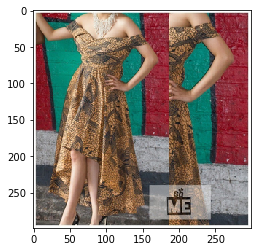

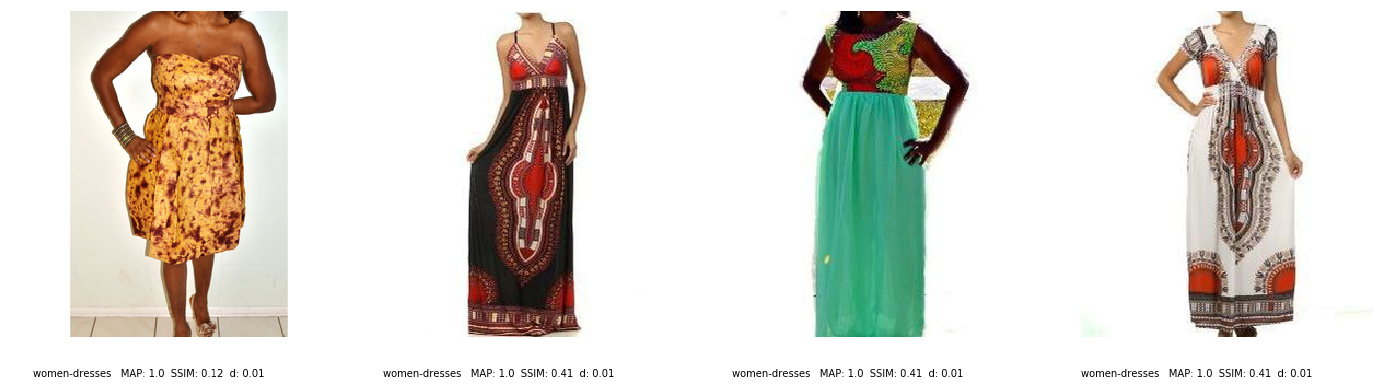

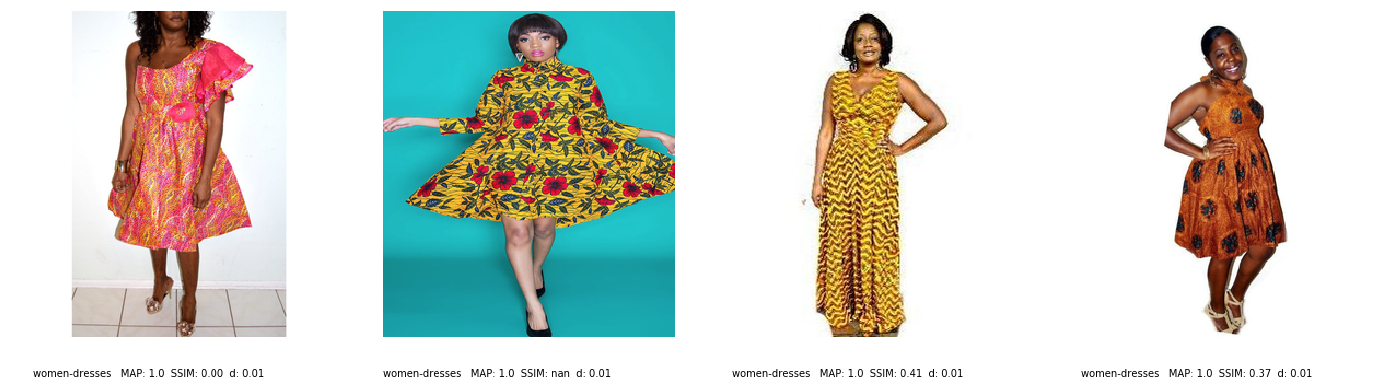

In [359]:
sanity_test_url = dresses_set[13]
test_sanity(sanity_test_url)

# Test Model

Prep STREET URLS <br>
<b> SKIP BELOW FOR TEST STREET URLS </b>

In [10]:
def get_street_images_url():
    GENDER_I = 6
    PRODUCT_ID = 8
    all_street_urls = []
    # unique products 
    unique_street_urls = [] #expect: 4181
    products_added = []

    
    for key in test_embeddings: 
        if key[GENDER_I] == "others": continue 
        all_street_images_urls.append(key)
        product = key[PRODUCT_ID]
        if product not in products_added:
            products_added.append(product)
            unique_street_urls.append(product)
            
    return all_street_urls, unique_street_urls

In [11]:
# segregates dress from non-dress
def segregate_street_urls(url_list):
    CATEGORY_INDEX = 7
    dresses_urls = []
    non_dress_urls = []
    for url in url_list:
        if url[CATEGORY_INDEX] == "women-dresses":
            dresses_urls.append(url)
        else: 
            non_dress_urls.append(url)
    return dresses_urls, non_dress_urls

In [ ]:
all_street_urls, unique_street_urls = get_street_images_url()
all_street_dress, all_street_non_dress = segregate_street_urls(all_street_urls)
u_street_dress, u_street_non_dress = segregate_street_urls(unique_street_urls)

<b>GET TEST STREET URLS </b>
    (1000K URLS RESERVED FOR TESTING) 

In [ ]:
street_test_urls = pickle.load(open( "street_test_urls.p", "rb" ) )

In [ ]:
test_neighbors_set = get_neighbors_set(street_test_urls, knn_file)

In [12]:
def test_model(urls_list, neighbors_set):
    print "RESULTS: "
    num_rec = 8
    cat_map, hist_map = 0,0 
    acc_factor = 1.0/len(urls_list)

    for i in range(len(urls_list)):
        cat_acc, hss_acc =  get_scorings(urls_list[i], neighbors_set[i], train_urls, num_rec=num_rec)
        if i % 100 == 0: print i 
        cat_map += (cat_acc*acc_factor)
        hist_map += (hss_acc*acc_factor)

    print "Cat MAP: ", cat_map, "hist_map: ",hist_map
    return cat_map, hist_map

In [ ]:
test_cat_map, test_hist_map = test_model(street_test_urls, test_neighbors_set)

<b>Run it on the whole street dataset</b>

In [ ]:
all_street_neighbors_set = get_neighbors_set(all_street_urls, knn_file)

In [ ]:
street_cat_map, street_hist_map = test_model(all_street_urls, all_street_neighbors_set)

<b> TRAINING ACCURACY</b> <br>
Run it on all stock images

In [ ]:
train_neighbors_set = get_train_neighbors_set(train_urls, knn_file)

In [ ]:
train_cat_map, train_hist_map = test_model(train_urls, train_neighbors_set)

# Visualize Results

MAP:  1.0
Query:  women-dresses


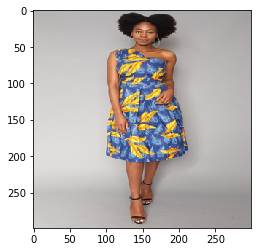

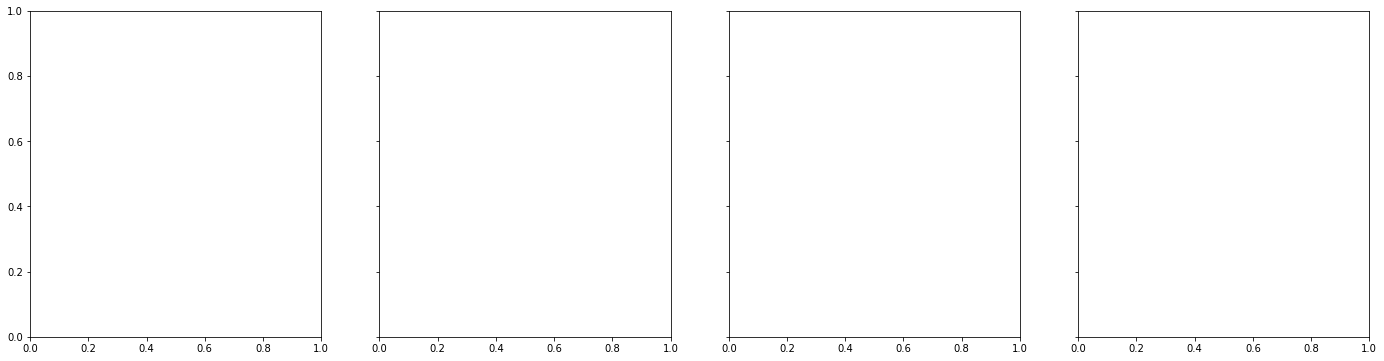

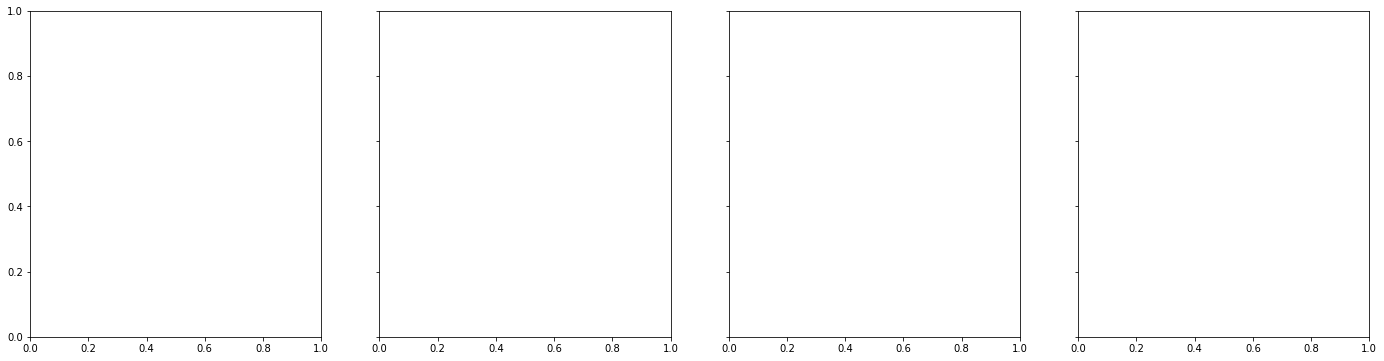

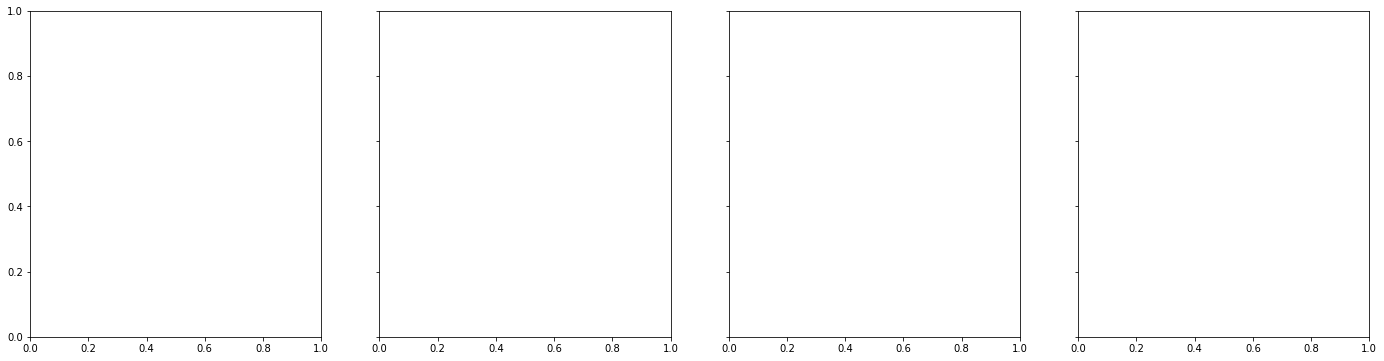

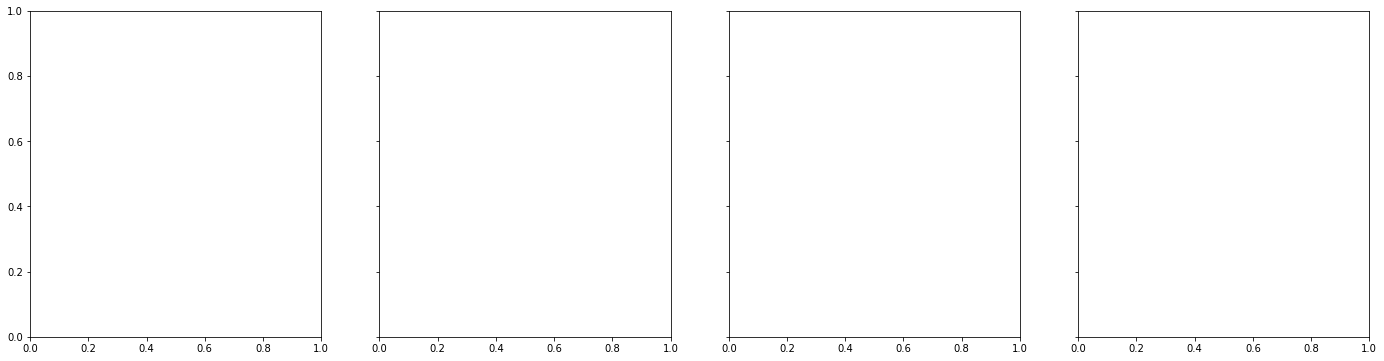

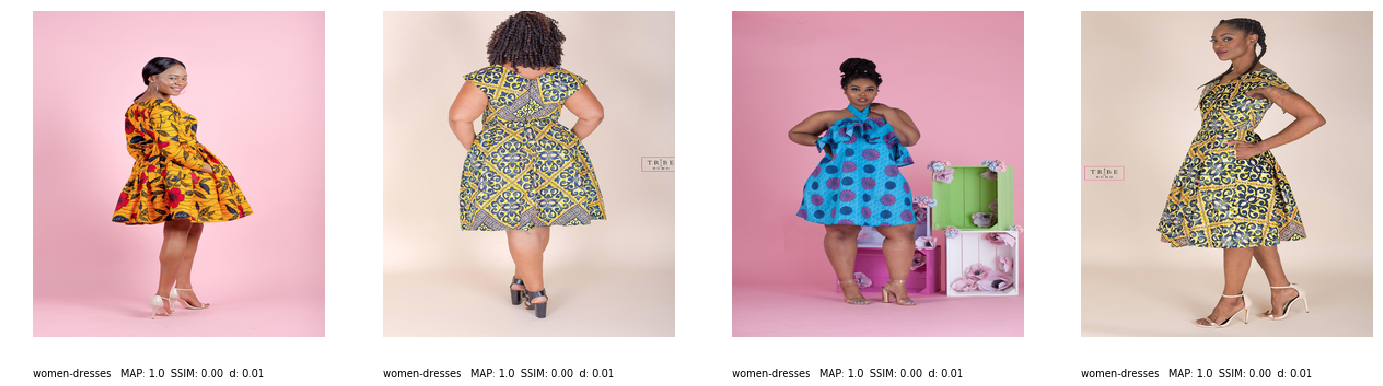

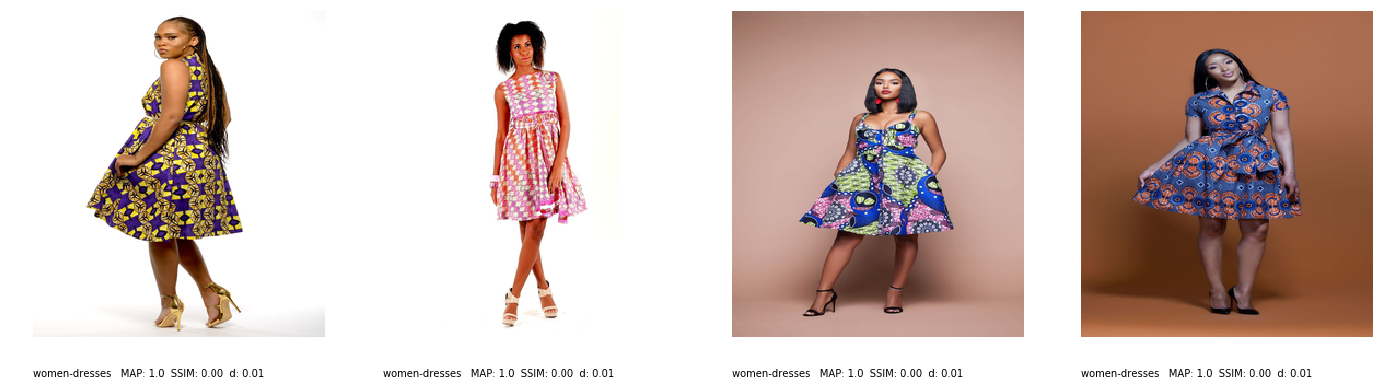

In [162]:
i = 179
num_rec = 8
print "MAP: ", get_scorings(test_urls[i], dress_neighbors_set[i], train_urls, num_rec=num_rec)[0]
plot_neighbors(test_urls[i], dress_neighbors_set[i], train_urls, top=num_rec, per_row=4)